<a href="https://colab.research.google.com/github/franklinroosevelth/deep_learning/blob/main/detection_object_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [3]:
# Télécharger le fichier des labels COCO
!wget -O coco.names https://github.com/pjreddie/darknet/raw/master/data/coco.names

# Télécharger le fichier de configuration YOLOv3
!wget -O yolov3.cfg https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg

# Télécharger le fichier de poids YOLOv3
!wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights


--2024-06-26 15:18:11--  https://github.com/pjreddie/darknet/raw/master/data/coco.names
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names [following]
--2024-06-26 15:18:12--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘coco.names’

coco.names          100%[===================>]     625  --.-KB/s    in 0s      

2024-06-26 15:18:12 (26.8 MB/s) - ‘coco.names’ saved [625/625]

--2024-06-26 15:18:12--  https://github.com/pjreddie/darknet/raw/master/cfg/yolo

In [30]:
ROOT_COLAB = '/content/'
COCO_LABELS_FILE = ROOT_COLAB + 'coco.names'
YOLO_CONFIG_FILE = ROOT_COLAB + 'yolov3.cfg'
YOLO_WEIGHTS_FILE = ROOT_COLAB + 'yolov3.weights'
IMAGE_FILE = 'orid_bureau.jpg'
IMAGE = cv2.imread(ROOT_COLAB + IMAGE_FILE)
CONFIDENCE_MIN = 0.5

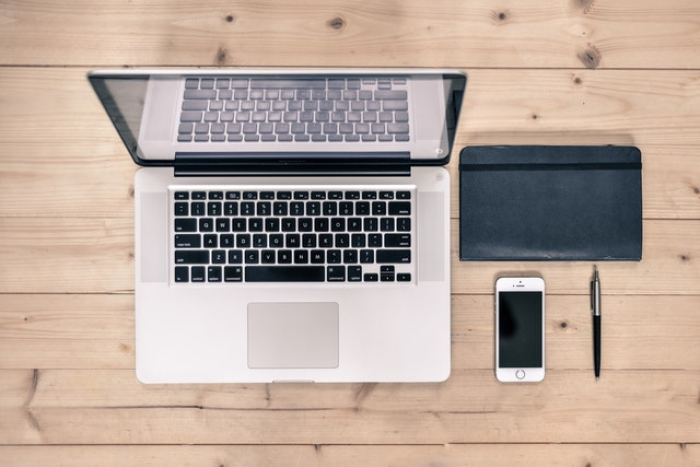

In [33]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    image = image.copy()
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    return cv2.resize(image, dim, interpolation=inter)

cv2_imshow(ResizeWithAspectRatio(IMAGE, width=700))

In [35]:
with open(COCO_LABELS_FILE, 'rt') as f:
    labels = f.read().rstrip('\n').split('\n')

labels

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [36]:
np.random.seed(45)
BOX_COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

In [37]:
yolo = cv2.dnn.readNetFromDarknet(YOLO_CONFIG_FILE, YOLO_WEIGHTS_FILE)

# Correction de l'obtention des noms de couches YOLO
layer_names = yolo.getLayerNames()
yololayers = [layer_names[i - 1] for i in yolo.getUnconnectedOutLayers().flatten()]

blobimage = cv2.dnn.blobFromImage(IMAGE, 1 / 255.0, (416, 416), swapRB=True, crop=False)
yolo.setInput(blobimage)

In [38]:
# Exécuter une passe avant pour obtenir les sorties de couche YOLO
layerOutputs = yolo.forward(yololayers)

H, W = IMAGE.shape[:2]
detections = {}

# Boucler sur chacune des sorties de couche
for output in layerOutputs:
    # Boucler sur chacune des détections
    for detection in output:
        # Extraire l’ID de classe et la confiance (c.-à-d. la probabilité) de la détection de l’objet courant
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        # Ne prendre que les prédictions avec plus de confiance que CONFIDENCE_MIN
        if confidence > CONFIDENCE_MIN:
            # Zone de délimitation
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")
            # Utiliser les coordonnées centrales (x, y) pour obtenir les coins haut et gauche de la zone de délimitation
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            # Vérifier si c'est la détection avec la confiance la plus élevée pour cette classe d'objet
            if classID not in detections or confidence > detections[classID][0]:
                detections[classID] = (confidence, x, y, int(width), int(height))

In [39]:
# Tracer les rectangles de délimitation pour les détections avec la confiance la plus élevée pour chaque classe d'objet
for classID, (confidence, x, y, w, h) in detections.items():
    color = [int(c) for c in BOX_COLORS[classID]]
    score = str(round(float(confidence) * 100, 1)) + "%"
    text = "{}: {}".format(labels[classID], score)

    cv2.rectangle(IMAGE, (x, y), (x + w, y + h), color, 2)
    cv2.putText(IMAGE, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


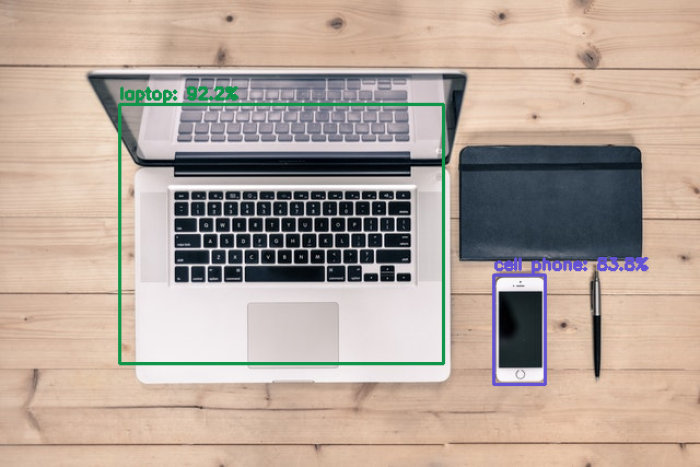

In [40]:
# Afficher l'image avec les boites de délimitation
cv2_imshow(ResizeWithAspectRatio(IMAGE, width=700))